# Importing required files

In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import sys
import os.path
import math
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from tqdm import tqdm

import config
import data
import model
import utils

import h5py
from PIL import Image
from torch.autograd import Variable
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.models as models

import config
import data
import utils
from resnet import resnet as caffe_resnet

# Wrote custom functions to process input to the neural network

In [3]:
def prepare_questions(questions):
    '''
    Remove punctuation marks and spaces. Returns list
    '''
    questions = [questions]
    for question in questions:
        question = question.lower()[:-1]
        yield question.split(' ')

def encode_question(question):
    '''
    Encode questions
    Get ids using vocabulary created using tokens during training
    '''
    vec = torch.zeros(len(question)).long()
    with open(config.vocabulary_path, 'r') as fd:
        vocab_json = json.load(fd)
    token_to_index = vocab_json['question']
    for i, token in enumerate(question):
        index = token_to_index.get(token, 0)
        vec[i] = index
    return vec, len(question)

class Net(nn.Module):
    '''
    Loading Resnet pretrained model to get image features
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.model = caffe_resnet.resnet152(pretrained=True)

        def save_output(module, input, output):
            self.buffer = output
        self.model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.model(x)
        return self.buffer


def encode_img(net,img_path):
    '''
    Encoding input image using Resnet features. Resizes input image to config.image_size
    '''
    cudnn.benchmark = True
    transform = utils.get_transform(config.image_size, config.central_fraction)
    img = Image.open(img_path).convert('RGB')
    img = transform(img)
    ix,iy = img.size()[1],img.size()[2]
    net = Net().cuda()
    net.eval()
    with torch.no_grad():
        img = Variable(img.cuda(non_blocking=True))
        out = net(img.view(1,3,ix,iy))
        features = out.data.cpu().numpy().astype('float32')
    return features


# Run Demo below 

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import skimage
import skimage.transform
import torch
import model

def demo(img_path,question):
    '''
    Main demo function. Takes input image path and Question string as input
    Returns top 5 answers, shows input image and visualizes attention applied 
    '''
    print('The Question asked was: ',question)
    cudnn.benchmark = True
    # Load pre-trained image
    # Download from https://github.com/snagiri/ECE285_Jarvis_ProjectA/releases/download/v1.0/50epoch.pth
    log = torch.load('50epoch.pth')
    tokens = len(log['vocab']['question']) + 1
    net = model.Net(tokens)
    net.load_state_dict(log['weights'])
    net.eval()
    
    questions = list(prepare_questions(question))
    questions = [encode_question(q) for q in questions]
    q,q_len = questions[0]
    q = q.unsqueeze(0)

    v = encode_img(net,img_path)
    v = torch.from_numpy(v).to(torch.float)
    q_len = torch.tensor([q_len])
    with torch.no_grad():
        v = Variable(v)
        q = Variable(q)
        q_len = Variable(q_len)  
    
    out,att_out = net.forward(v,q,q_len)
    out = out.data.cpu()
    _, answer5 = torch.topk(out,5)
    answers = []
    with open(config.vocabulary_path, 'r') as fd:
        vocab_json = json.load(fd)
    a_to_i = vocab_json['answer']
    for answer in answer5:
        answer = (answer.view(-1))
        for a in answer.data:
            answers.append(list(a_to_i.keys())[a.data])        
    print_answers(answers)
    visualize_attentn(att_out,img_path)
    return

def visualize_attentn(att_out,img_path):
    '''
    Takes output of attention layer and overlays on input image. Then shows both 
    '''
    att_out = att_out.view(-1,14,14)
    num_im = att_out.size()[0]
    im = Image.open(img_path)
    fig2,ax2 = plt.subplots(1)
    ax2.imshow(im)
    ax2.set_title('Original Image')
    ax2.axis('off')
    fig,axs = plt.subplots(1,num_im,figsize=(10,10))
    axs = axs.ravel()
    for i in range(0,num_im):
        a1 = att_out[i].cpu().detach()
        a1 = a1.numpy()
        a1 = skimage.transform.pyramid_expand(a1, upscale=64,multichannel=False)
        im = im.resize(a1.shape)
        axs[i].imshow(im)
        axs[i].imshow(a1,cmap='gray',alpha=0.65)
        axs[i].set_title('Attention image '+str(i))
    for ax in axs:
        ax.axis('off')
    return

def print_answers(answers):
    '''
    Function to print top 5 answers
    '''
    for i,a in enumerate(answers):
        print("The top ",i+1," answer is ",a)
    return

# __The results of demo are show below__

Here the system gets the answer right. We can see the attention output also focusing on the umbrella

The Question asked was:  What color is the umbrella?
The top  1  answer is  red
The top  2  answer is  pink
The top  3  answer is  orange
The top  4  answer is  blue
The top  5  answer is  red and white


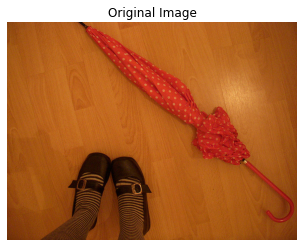

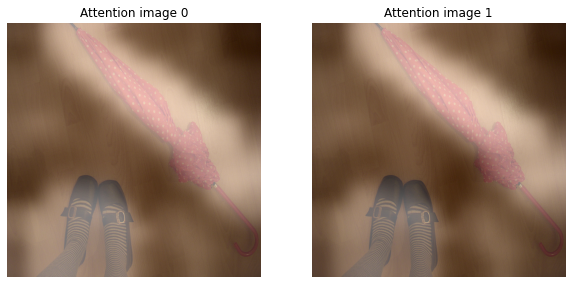

In [7]:
demo('test_img.jpg','What color is the umbrella?')

Here the system gets the answer wrong. But the 2nd answer was right. Input image is taken from MS COCO v1 validation set from VQA website

The Question asked was:  Is the umbrella yellow?
The top  1  answer is  yes
The top  2  answer is  no
The top  3  answer is  red
The top  4  answer is  maybe
The top  5  answer is  pink


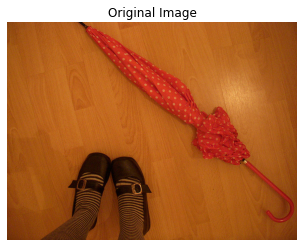

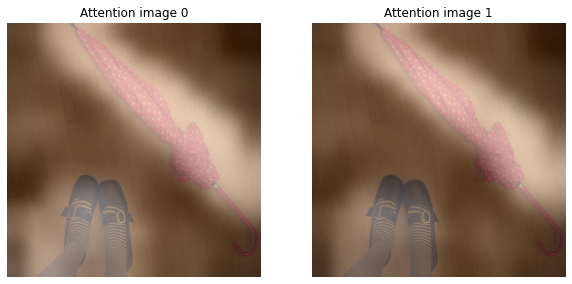

In [8]:
demo('test_img.jpg','Is the umbrella yellow?')

Here the system gets it right. We can see more attention applied on the shoes than above

The Question asked was:  What color are the shoes?
The top  1  answer is  black
The top  2  answer is  brown
The top  3  answer is  red
The top  4  answer is  white
The top  5  answer is  orange


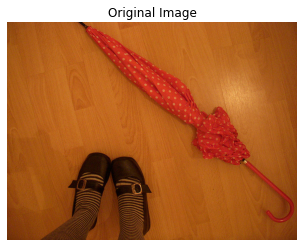

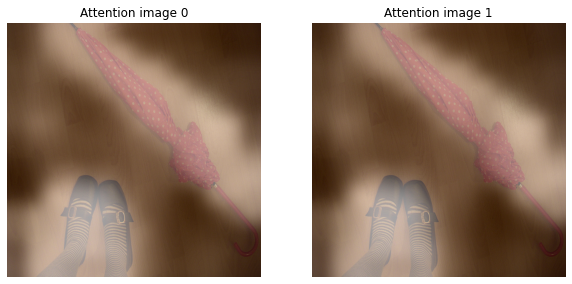

In [9]:
demo('test_img.jpg','What color are the shoes?')

This image is taken from Googling for tennis images. The system gets both questions right. It also gets questions like 'is the woman playing tennis?' and 'Is she playing badminton?' right

The Question asked was:  What is the color of the dress?
The top  1  answer is  black
The top  2  answer is  green
The top  3  answer is  yellow
The top  4  answer is  red
The top  5  answer is  black and white


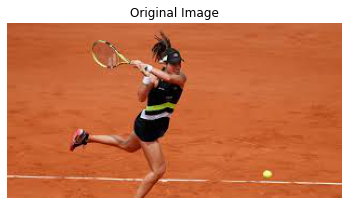

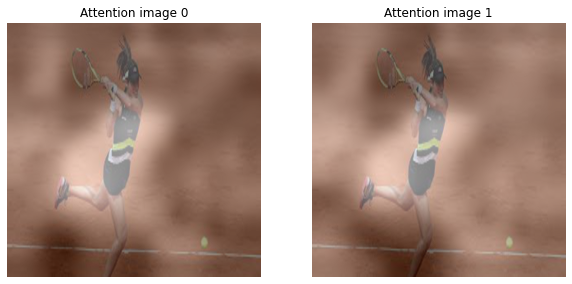

In [10]:
demo('tennis.jpg','What is the color of the dress?')

The Question asked was:  What is she playing?
The top  1  answer is  tennis
The top  2  answer is  tennis court
The top  3  answer is  badminton
The top  4  answer is  court
The top  5  answer is  frisbee


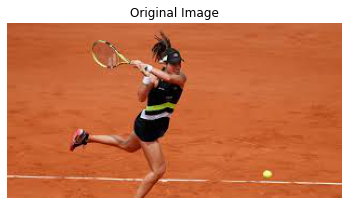

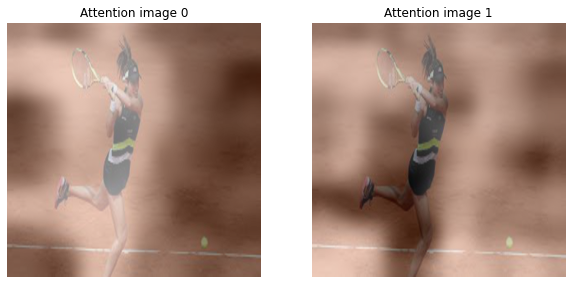

In [11]:
demo('tennis.jpg','What is she playing?')

This image is taken from googling for dogs. The answer is ambiguous since I cannot tell where the dogs are but the output options are reasonable

The Question asked was:  How many dogs are there?
The top  1  answer is  2
The top  2  answer is  3
The top  3  answer is  4
The top  4  answer is  5
The top  5  answer is  6


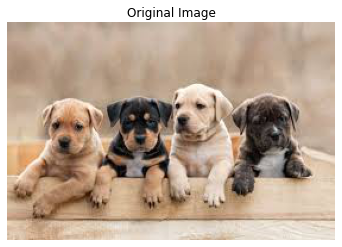

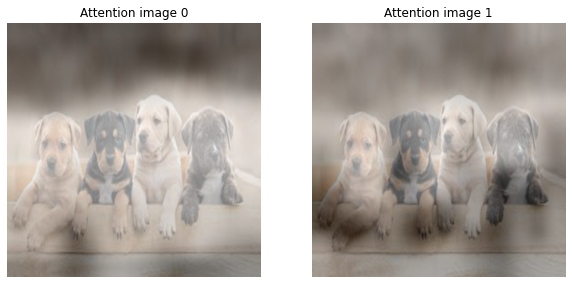

In [13]:
demo('dogs.jpg','How many dogs are there?')

# __To plot accuracy and loss graphs__

The evaluation was run on the MS COCO v1 validation set on every epoch.
We can see that loss starts to increase after 20 epochs which points to overfitting but accuracy does not drop.

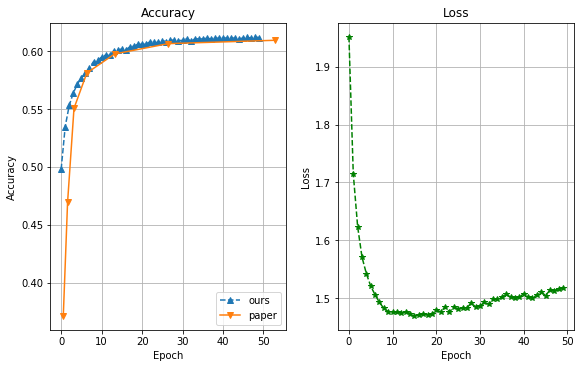

In [4]:
path = '50epoch.pth'
results = torch.load(path)

l =[37.16,46.96,55.07,58.12,59.76,60.65,60.94]
l = [i/100 for i in l]
x = [1000,3000,6000,12000,25000,50000,100000]
x = [i/1890 for i in x]

val_acc = torch.FloatTensor(results['tracker']['val_acc'])
val_acc = val_acc.mean(dim=1).numpy()

val_loss = torch.FloatTensor(results['tracker']['val_loss'])
val_loss = val_loss.mean(dim=1).numpy()

fig,ax = plt.subplots(1,2,figsize=(8,5),constrained_layout=True)
ax[0].plot(val_acc,'--^',label='ours')
ax[0].plot(x,l,marker='v',label='paper')
ax[1].plot(val_loss,'--*',color='green')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[0].grid(which='both')
ax[1].grid(which='both')